In [ ]:
!pip install -U scikit-learn -i https://pypi.tuna.tsinghua.edu.cn/simple

In [112]:
!pip install mplfinance -i https://pypi.tuna.tsinghua.edu.cn/simple

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     |████████████████████████████████| 75 kB 1.5 MB/s eta 0:00:011
     |████████████████████████████████| 12.4 MB 7.1 MB/s eta 0:00:01
     |████████████████████████████████| 502 kB 13.9 MB/s eta 0:00:01
     |████████████████████████████████| 346 kB 13.9 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [1]:
import tensorflow as tf
import api.capital_features_api as cf
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, InputLayer, GRU
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras import regularizers
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import backend as K

scaler = StandardScaler()
tf.config.list_physical_devices(device_type='GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [70]:
train_data = cf.get_train_data(cf.docker_train_data_url, train_config_id=7)
validation_data = cf.get_train_data(cf.docker_train_data_url, train_config_id=26988)

In [71]:
X_train = np.array(train_data['featuresT'])
X_val = np.array(validation_data['featuresT'])

In [151]:
train_down = train_data['downSignals']
val_down = validation_data['downSignals']
train_up = train_data['upSignals']
val_up = validation_data['upSignals']
Y_train = train_down
Y_val = val_down

In [152]:
# 获取形状信息
num_samples, num_timesteps, num_features = X_train.shape
# 将三维特征数组重塑为二维
X_train_reshaped = X_train.reshape(-1, num_features)
# 使用训练集的数据来拟合scaler
scaler.fit(X_train_reshaped)

# 标准化训练数据
X_train_scaled = scaler.transform(X_train_reshaped).reshape(num_samples, num_timesteps, num_features)
# 同样的，将验证集（如果有的话）重塑并转换
num_samples_val, num_timesteps_val, num_features_val = X_val.shape
X_val_reshaped = X_val.reshape(-1, num_features_val)
X_val_scaled = scaler.transform(X_val_reshaped).reshape(num_samples_val, num_timesteps_val, num_features_val)

In [153]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_scaled, Y_train))
validation_dataset = tf.data.Dataset.from_tensor_slices((X_val_scaled, Y_val))
BATCH_SIZE = 64  # 你可以根据需要调整这个值
train_dataset = train_dataset.batch(BATCH_SIZE)
validation_dataset = validation_dataset.batch(BATCH_SIZE)

In [154]:
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(Y_train),
    y=Y_train
)
class_weights = dict(zip(np.unique(Y_train), weights))

In [155]:
def max_acc(y_true, y_pred):
    # 设定一个阈值来确定分类（例如，0.5）
    threshold = 0.5
    y_pred = tf.cast(y_pred >= threshold, tf.float32)

    # 这里，我们将False Negatives的权重设为0，也就是说它们不计入总的损失
    fn_weight = 0.2
    fp_weight = 1.0  # False Positives的权重
    tn_weight = 1.0  # True Negatives的权重
    tp_weight = 1.0  # True Positives的权重

    # 计算不同类型错误的数量
    tp = K.sum(tp_weight * y_true * y_pred)
    fp = K.sum(fp_weight * (1 - y_true) * y_pred)
    fn = K.sum(fn_weight * y_true * (1 - y_pred))
    tn = K.sum(tn_weight * (1 - y_true) * (1 - y_pred))

    # 计算自定义评估指标
    # 在这个例子中，我们只计算被正确分类的样本的比例作为评估指标
    custom_score = (tp + tn) / (tp + fp + fn + tn)
    return custom_score

In [156]:
model = Sequential([
    tf.keras.layers.InputLayer(input_shape=(5, 40)),
    LSTM(128, return_sequences=True, kernel_regularizer=l2(0.001)),
    Dropout(0.2),
    BatchNormalization(),
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    BatchNormalization(),
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.2),
    Dense(1, activation='sigmoid'),
])

model.summary()
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy', 'Precision', 'Recall', max_acc]
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    mode='min',
    verbose=1,
    patience=20,
    restore_best_weights=True
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    mode='min',
    factor=0.5,
    patience=4,
    min_lr=1e-5,
    verbose=1
)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_22 (LSTM)              (None, 5, 128)            86528     
                                                                 
 dropout_33 (Dropout)        (None, 5, 128)            0         
                                                                 
 batch_normalization_22 (Bat  (None, 5, 128)           512       
 chNormalization)                                                
                                                                 
 lstm_23 (LSTM)              (None, 64)                49408     
                                                                 
 dropout_34 (Dropout)        (None, 64)                0         
                                                                 
 batch_normalization_23 (Bat  (None, 64)               256       
 chNormalization)                                    

In [157]:
his_up = model.fit(train_dataset, epochs=100, validation_data=validation_dataset, verbose=1,
                   callbacks=[early_stopping, reduce_lr], class_weight=class_weights)

Epoch 1/100
750/750 [==============================] - 23s 24ms/step - loss: 0.7730 - accuracy: 0.6007 - precision: 0.4190 - recall: 0.6159 - max_acc: 0.6667 - val_loss: 1.0468 - val_accuracy: 0.3926 - val_precision: 0.3147 - val_recall: 0.7928 - val_max_acc: 0.4258 - lr: 0.0010
Epoch 2/100
750/750 [==============================] - 17s 23ms/step - loss: 0.6718 - accuracy: 0.6599 - precision: 0.4804 - recall: 0.6665 - max_acc: 0.7219 - val_loss: 1.0689 - val_accuracy: 0.3864 - val_precision: 0.3173 - val_recall: 0.8276 - val_max_acc: 0.4135 - lr: 0.0010
Epoch 3/100
750/750 [==============================] - 17s 22ms/step - loss: 0.6347 - accuracy: 0.6789 - precision: 0.5017 - recall: 0.6801 - max_acc: 0.7399 - val_loss: 1.0184 - val_accuracy: 0.4041 - val_precision: 0.3180 - val_recall: 0.7837 - val_max_acc: 0.4391 - lr: 0.0010
Epoch 4/100
750/750 [==============================] - 16s 22ms/step - loss: 0.6114 - accuracy: 0.6960 - precision: 0.5215 - recall: 0.6963 - max_acc: 0.7552 - 

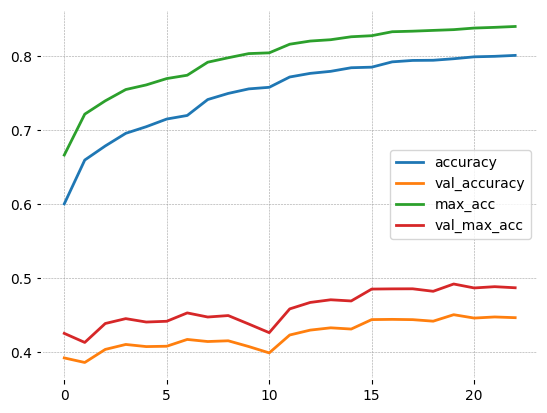

In [158]:
plt.plot(his_up.history['accuracy'], label='accuracy')
plt.plot(his_up.history['val_accuracy'], label='val_accuracy')
plt.plot(his_up.history['max_acc'], label='max_acc')
plt.plot(his_up.history['val_max_acc'], label='val_max_acc')
plt.legend()
plt.show()

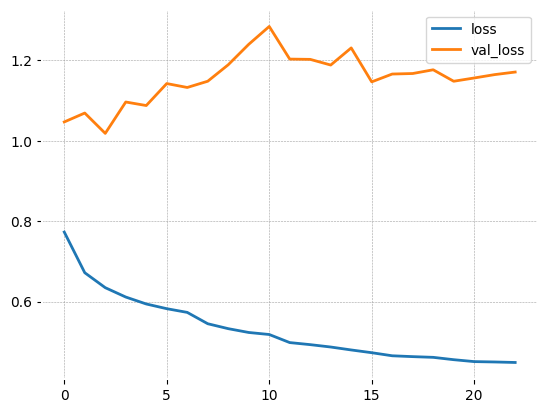

In [159]:
plt.plot(his_up.history['loss'], label='loss')
plt.plot(his_up.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [171]:
prediction_data = cf.get_prediction_data(cf.docker_prediction_data_url, train_config_id=7, start="2023-01-01", end=datetime.now().strftime("%Y-%m-%d"), code='ADBE')

In [172]:
X_prediction = np.array(prediction_data['knodeTrains']['featuresT'])

In [173]:
num_samples_prediction, num_timesteps_prediction, num_features_prediction = X_prediction.shape
X_prediction_reshaped = X_prediction.reshape(-1, num_features_prediction)
X_prediction_scaled = scaler.transform(X_prediction_reshaped).reshape(num_samples_prediction, num_timesteps_prediction,
                                                                      num_features_prediction)

In [174]:
Y_prediction = model.predict(X_prediction_scaled)

4/4 [==============================] - 0s 9ms/step


In [175]:
import requests
import json
from datetime import datetime
import mplfinance as mpf
import pandas as pd

In [176]:
payload = json.dumps({
    "code": "ADBE",
    "start": "2023-07-25",
    "end": "2024-01-24",
    "interval": "1d",
    "engine": "YAHOO_CHART"
})

headers = {
    'Content-Type': 'application/json'
}

response = requests.request("POST", cf.dev_docker_host + "/stock_/history", headers=headers, data=payload)
his = json.loads(response.text)

In [177]:
# 创建一个DataFrame:
df = pd.DataFrame(his)

# 转换’date’列为pandas的Datetime类型:
df['date'] = pd.to_datetime(df['date'])

# 设置date列为索引:
df.set_index('date', inplace=True)

# 按日期升序排序（如果数据未按日期排序的话）:
df.sort_index(inplace=True)

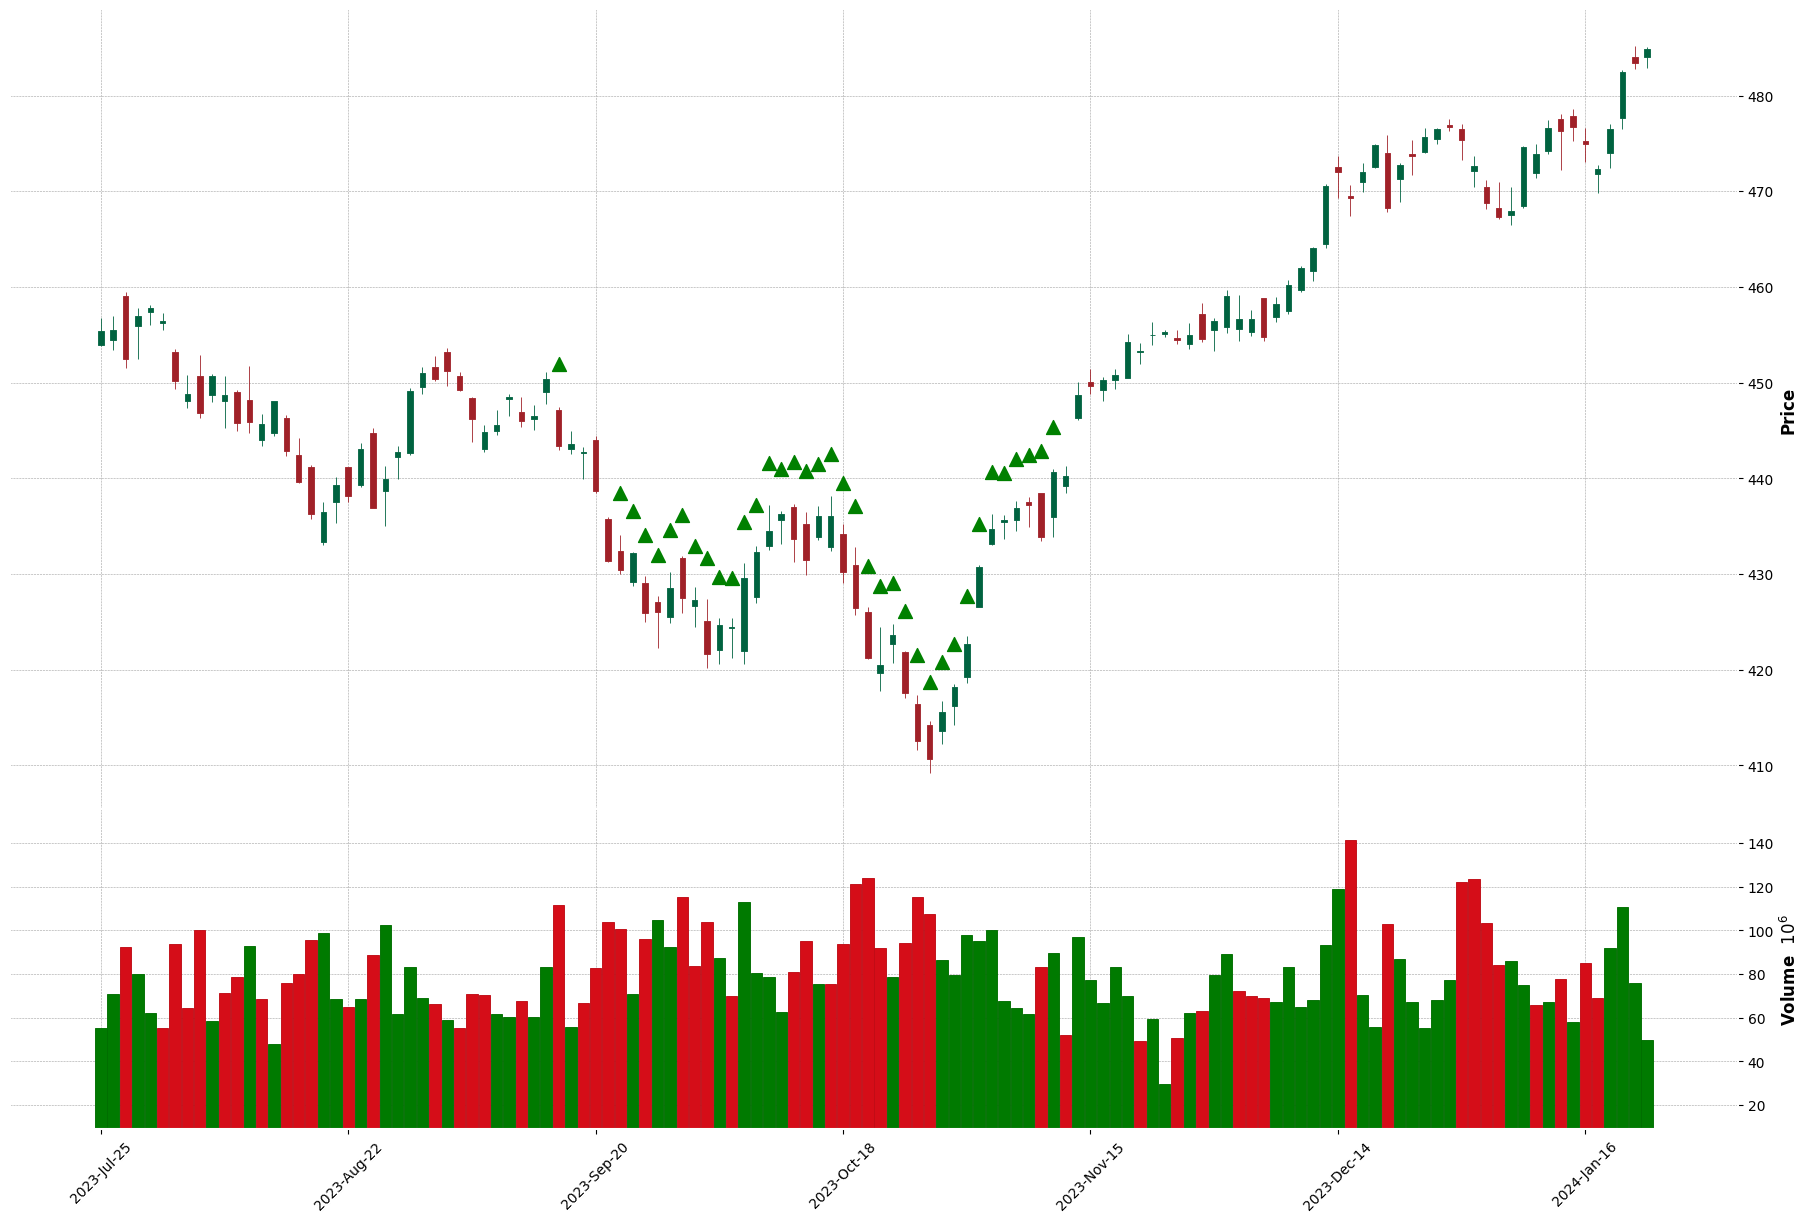

In [150]:
# 创建与 DataFrame 索引对齐的 pandas Series 以便于在逻辑过滤时能够正确地进行索引
predictions_series = pd.Series(Y_prediction.flatten(), index=df.index)

# 创建看涨信号标记（只包含预测值大于 0.5 的），结果为一个 numpy 数组
# 其中，高于对应最高价 1% 的价格作为图上的标记点。我们初始化所有值为 NaN，并仅在条件满足时进行填充
buy_signals = np.full(df.shape[0], np.nan)  # 含 NaN 的数组，与 df 的长度一致
buy_signals[predictions_series > 0.75] = df['high'][predictions_series > 0.75] * 1.01
buy_markers = mpf.make_addplot(buy_signals, type='scatter', markersize=100, marker='^', color='g')

# 最后，使用 mpf.plot 绘制 K 线图和自定义标记
mpf.plot(df, type='candle', style='charles', addplot=buy_markers, volume=True, figsize=(24, 16))


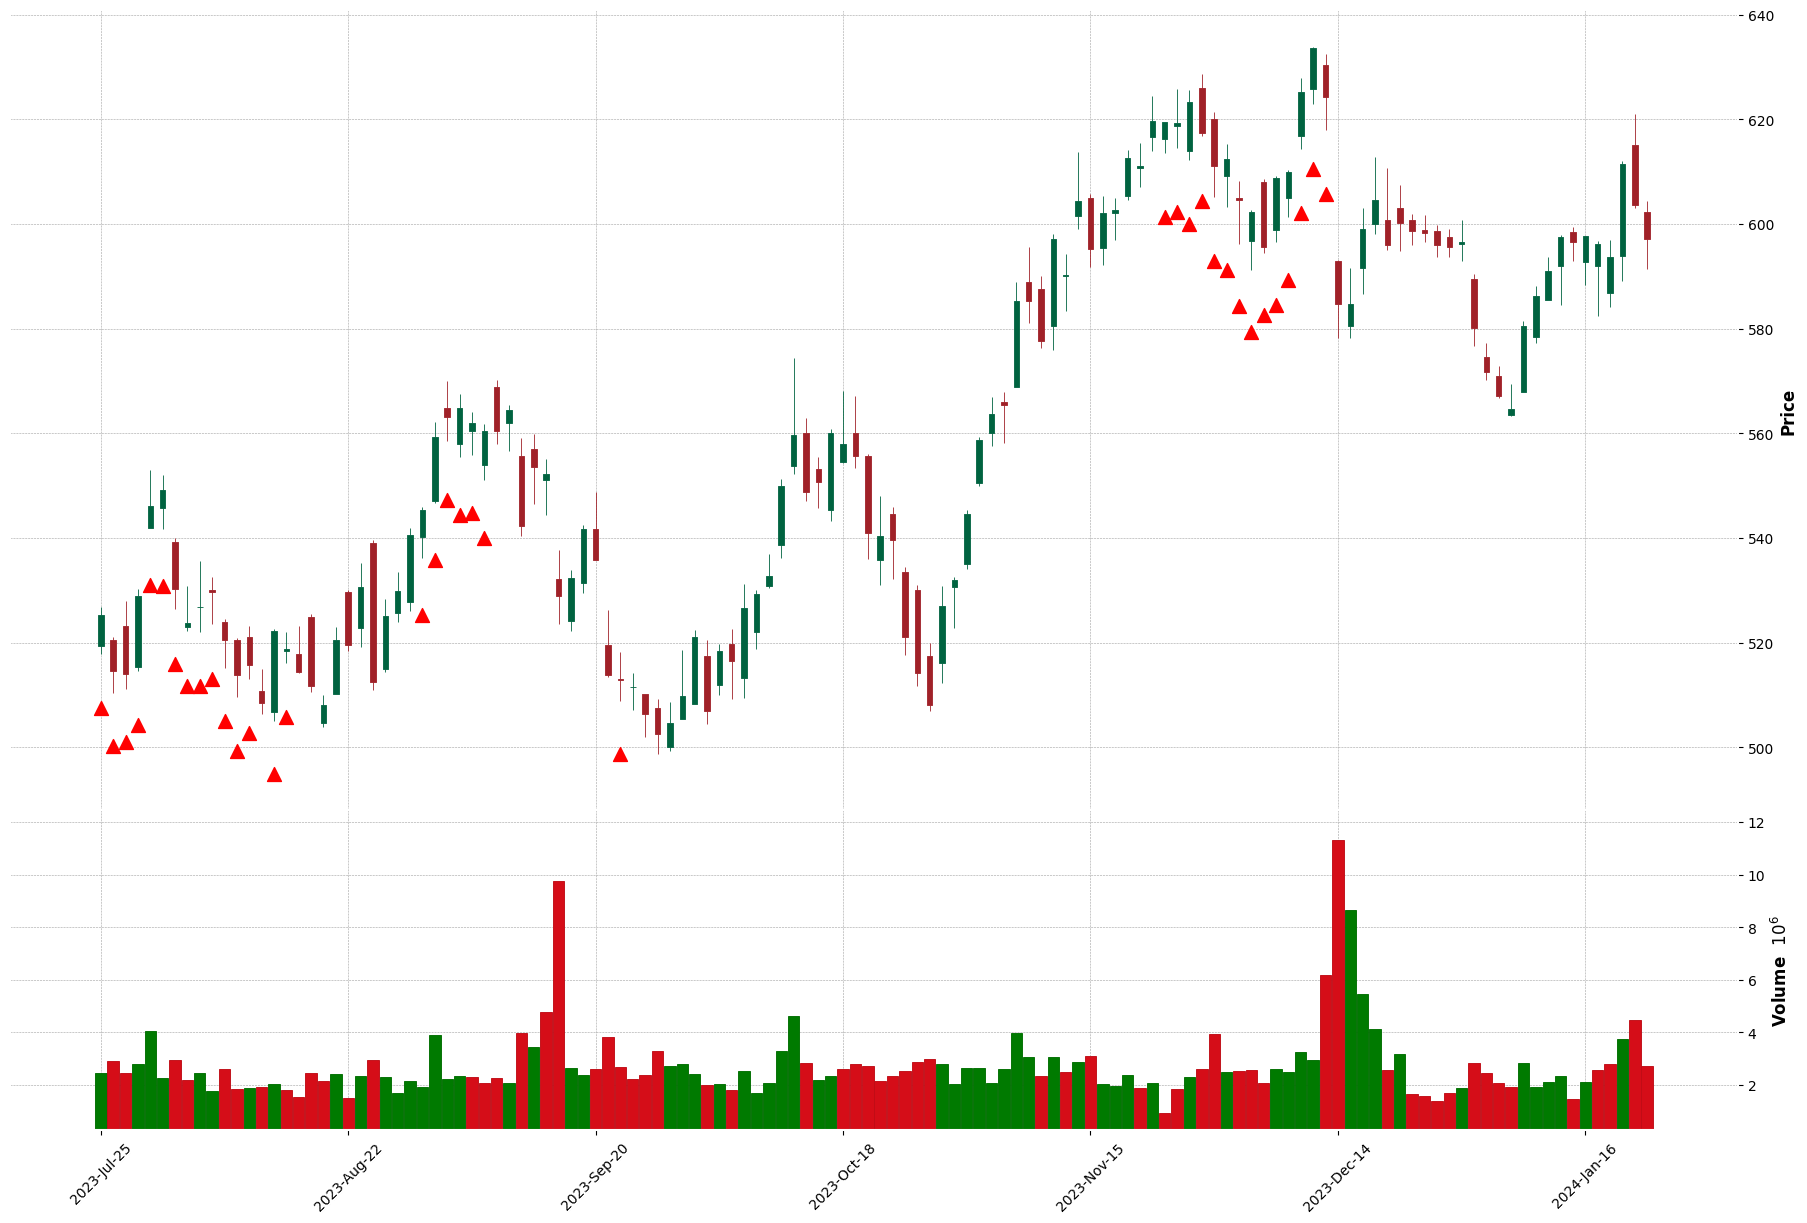

In [178]:
# 创建与 DataFrame 索引对齐的 pandas Series 以便于在逻辑过滤时能够正确地进行索引
predictions_series = pd.Series(Y_prediction.flatten(), index=df.index)

# 创建看涨信号标记（只包含预测值大于 0.5 的），结果为一个 numpy 数组
# 其中，高于对应最高价 1% 的价格作为图上的标记点。我们初始化所有值为 NaN，并仅在条件满足时进行填充
buy_signals = np.full(df.shape[0], np.nan)  # 含 NaN 的数组，与 df 的长度一致
buy_signals[predictions_series > 0.75] = df['low'][predictions_series > 0.75] * 0.98
buy_markers = mpf.make_addplot(buy_signals, type='scatter', markersize=100, marker='^', color='r')

# 最后，使用 mpf.plot 绘制 K 线图和自定义标记
mpf.plot(df, type='candle', style='charles', addplot=buy_markers, volume=True, figsize=(24, 16))


In [138]:
len(Y_prediction)

126